# Calculation of isoprenol concentrations for the recommendations generated using ART

Tested using **biodesign_3.7** kernel on the jprime.lbl.gov server. It uses the cplex library for running the MOMA optimization

#### ! TODO

The two files that are necessary for the notebook to run are:
<!--    - A modified E. coli model with the isopentenol pathway added to it (`iJO1366_MVA.json` file in the `../data/models` directory)
   - A set of designs (e.g. `../data/ice_mo_strains.csv` exported from ICE) containing the details of which reactions are either:
       - (0) eliminated 
       - (1) included
       - (2) doubled the flux -->

#### Running the cells below will generate the following output files, stored in the user defined output directory:

- For EDD import:
    - `experiment_description_file.csv`
    - `fluxomics_synthetic_data_sample_linename.csv`
    - `metabolomics_synthetic_data_sample_linename.csv`
    - `proteomics_synthetic_data_sample_linename.csv`
    - `transcriptomics_synthetic_data_sample_linename.csv`
    - `external_metabolites.csv`
    - `OD_synthetic_sample.csv`
    
    
- For Arrowland import:
    - `fluxomics_al_format_x_hrs_linename.csv`
    - `metabolomics_al_format_x_hrs_linename.csv`
    - `proteomics_al_format_x_hrs_linename.csv`
    - `transcriptomics_al_format_x_hrs_linename.csv`

## Setup

Clone the git repository with the `OMG` library:

`git clone https://github.com/JBEI/OMG.git --branch omgforallhosts --single-branch`

or pull the latest version.

In [1]:
import sys
import os

sys.path.insert(1, '../../OMG')
sys.path.append('../')

import cobra
import pandas as pd
import omg 
from plot_multiomics import *

## User parameters

In [54]:
user_params = {
    'host': 'ecoli', # ecoli or ropacus
    'modelfile': '../data/models/iJO1366_MVA.json',
    'cerevisiae_modelfile': '../data/models/iMM904.json', 
    'timestart': 0.0,
    'timestop': 8.0,
    'numtimepoints': 9,
    'designsfile': 'recommendations.csv',
    'designsfilepath': '../data/art_output',
    'mapping_file': '../mapping/inchikey_to_cid.txt',
    'output_file_path': 'data/omg_output',
    'edd_omics_file_path': '../data/omg_output/edd_rec/',
    'al_omics_file_path': '../data/omg_output/arrowland_rec/',
    'numreactions': 8,
    'numinstances': 10,
    'ext_metabolites': {
        'glc__D_e': 22.203,
        'nh4_e': 18.695,
        'pi_e': 69.454,
        'so4_e': 2.0,
        'mg2_e': 2.0,
        'k_e': 21.883,
        'na1_e': 103.7,
        'cl_e': 27.25,
        'isoprenol_e': 0.0,
        'ac_e': 0.0,
        'for_e': 0.0,
        'lac__D_e': 0.0,
        'etoh_e': 0.0
    },
    'initial_OD': 0.01,
    'BIOMASS_REACTION_ID': 'BIOMASS_Ec_iJO1366_core_53p95M'
} 

## Using the OMG library functions for creating synthetic multiomics data

### 1) Getting and preparing the metabolic model

First we obtain the metabolic model:

In [16]:
file_name = user_params['modelfile']
model = cobra.io.load_json_model(file_name)

Check if isopentenol pathway is present in the model, else add it using the *S. Cerevisiae* model

In [17]:
if not omg.model_has_IPP_pathway(model):
    print("Isopentenol pathway is present in the model")
    sce_filename = user_params['cerevisiae_modelfile']
    try:
        sce_model = cobra.io.load_json_model(sce_filename)
    except IOError:
        print("Could not read file:", sce_filename)
    else:
        # add pathway to model
        omg.add_isopentenol_pathway(model, sce_model)

We now add minimum flux constraints for production of isopentenol and formate, and we limit oxygen intake:

In [18]:
iso = 'EX_isoprenol_e'
iso_cons = model.problem.Constraint(model.reactions.EX_isoprenol_e.flux_expression,lb = 0.20)
model.add_cons_vars(iso_cons)
for_cons = model.problem.Constraint(model.reactions.EX_for_e.flux_expression,lb = 0.10)
model.add_cons_vars(for_cons)
o2_cons = model.problem.Constraint(model.reactions.EX_o2_e.flux_expression,lb = -8.0)
model.add_cons_vars(o2_cons)


And then we constrain several central carbon metabolism fluxes to more realistic upper and lower bounds:

In [19]:
CC_rxn_names = ['ACCOAC','MDH','PTAr','CS','ACACT1r','PPC','PPCK','PFL']
for reaction in CC_rxn_names:
    reaction_constraint = model.problem.Constraint(model.reactions.get_by_id(reaction).flux_expression,lb = -1.0,ub =  1.0)
    model.add_cons_vars(reaction_constraint)

We also create a similar model with a higher production of isopentenol, which we will use with MOMA to simulate bioengineered strains:

In [20]:
modelHI = model.copy()
iso_cons = modelHI.problem.Constraint(modelHI.reactions.EX_isoprenol_e.flux_expression,lb = 0.25)
modelHI.add_cons_vars(iso_cons)

### 2) Obtaining times series for the wild type

Create first time grid for simulation:

In [21]:
t0 = user_params['timestart']
tf = user_params['timestop']
points = user_params['numtimepoints']
tspan, delt = np.linspace(t0, tf, points, dtype='float64', retstep=True)

grid = (tspan, delt)

We then use this model to obtain the times series for fluxes, OD and external metabolites:

In [22]:
solution_TS, model_TS, cell, Emets, Erxn2Emet = \
    omg.get_flux_time_series(model, user_params['ext_metabolites'], grid, user_params)

0.0 optimal 0.5363612610171437
1.0 optimal 0.5363612610171437
2.0 optimal 0.5363612610171437
3.0 optimal 0.5363612610171437
4.0 optimal 0.5363612610171437
5.0 optimal 0.5363612610171437
6.0 optimal 0.5363612610171437
7.0 optimal 0.5363612610171437
8.0 optimal 0.5363612610171437


We perform the same calculation for the model with higher isoprenol production that we created above:

In [23]:
solutionHI_TS, modelHI_TS, cellHI, EmetsHI, Erxn2EmetHI = \
    omg.get_flux_time_series(modelHI, user_params['ext_metabolites'], grid, user_params)

0.0 optimal 0.5352266385352652
1.0 optimal 0.5352266385352652
2.0 optimal 0.5352266385352652
3.0 optimal 0.5352266385352652
4.0 optimal 0.5352266385352652
5.0 optimal 0.5352266385352652
6.0 optimal 0.5352266385352652
7.0 optimal 0.5352266385352652
8.0 optimal 0.5352266385352652


### 3) Getting bioengineered flux profiles through MOMA

First obtain the file from ICE with suggested designs (i.e. reactions kos and overexpressions):

In [27]:
rec_df = pd.read_csv(f'{user_params["designsfilepath"]}/{user_params["designsfile"]}')
rec_df.head()

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Mean predicted Isoprenol [mg/L],SD Isoprenol [mg/L]
0,Strain 97,2.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.573584,0.019785
1,Strain 98,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,0.572193,0.019752
2,Strain 99,1.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.572167,0.019752
3,Strain 100,2.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,0.572039,0.019787
4,Strain 101,2.0,2.0,1.0,2.0,2.0,1.0,0.0,1.0,0.571967,0.019780


We then use MOMA to calculate flux profiles at each time point for the recommended strains. Instead of using the solution time series corresponding to the initial model, we use the solution time series corresponding to the higher production. The reason is that, otherwise, we would never see an increase in isoprenol production, since MOMA minimizes the changes in flux by design. Remember that our goal here is just to create realistic flux profiles that can be used to showcase ART. This approach is good enough: 

In [33]:
%%time
solutionsMOMA_TS = {}
cols = designs_df.columns[:-2]

if user_params['numinstances'] not in [None, 0]:
    num_strains = user_params['numinstances']
else:
    num_strains = design_df.shape[0]

for i in range(num_strains):
    design = designs_df[cols].loc[i]
    if design['Line Name']=='WT':
        solutionsMOMA_TS[i] = omg.getBEFluxes(model_TS, design, solution_TS, grid)
    else:
        solutionsMOMA_TS[i] = omg.getBEFluxes(model_TS, design, solutionHI_TS, grid)

CPU times: user 10min 13s, sys: 4.47 s, total: 10min 18s
Wall time: 10min 19s


We can check that the knocked out fluxes are zero:

### 4) Producing the external metabolite concentrations for each recommendation

Here we use the `integrate_fluxes` function to produce the external metabolite concentrations compatible with the calculated fluxes:

In [35]:
cellsEmetsBE = {}
for i in range(num_strains):
    cell, Emets = omg.integrate_fluxes(solutionsMOMA_TS[i], model_TS, user_params['ext_metabolites'], grid, user_params)
    cellsEmetsBE[i] = (cell, Emets) 


CPU times: user 268 ms, sys: 0 ns, total: 268 ms
Wall time: 267 ms


Visualize obtained concentrations for a recommendation:

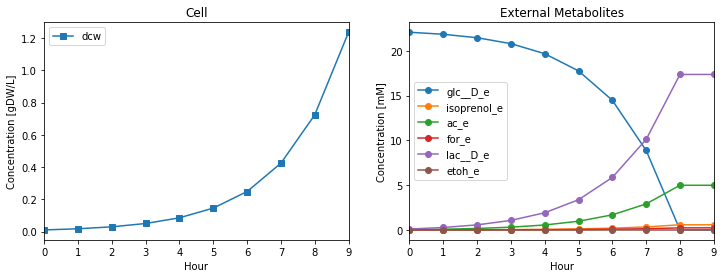

In [36]:
i = 2
cellBE, EmetsBE = cellsEmetsBE[i]
plot_DO_extmets(cellBE, EmetsBE[['glc__D_e','isoprenol_e','ac_e','for_e','lac__D_e','etoh_e']])

In [37]:
EmetsBE

,glc__D_e,nh4_e,pi_e,so4_e,mg2_e,k_e,na1_e,cl_e,isoprenol_e,ac_e,for_e,lac__D_e,etoh_e
0.0,22.0708,18.6185,69.4472,1.99821,1.99994,21.8816,103.7,27.25,0.00330624,0.0287831,0.0013225,0.100218,0
1.0,21.8449,18.488,69.4355,1.99517,1.99983,21.8793,103.7,27.2499,0.00895276,0.0779399,0.0035811,0.271374,0
2.0,21.4592,18.265,69.4156,1.98996,1.99965,21.8752,103.7,27.2498,0.0185961,0.161892,0.00743843,0.563679,0
3.0,20.8004,17.8842,69.3816,1.98107,1.99935,21.8683,103.7,27.2496,0.0350653,0.305267,0.0140261,1.06289,0
4.0,19.6753,17.2338,69.3235,1.96588,1.99883,21.8566,103.7,27.2493,0.0631919,0.550129,0.0252768,1.91546,0
5.0,17.7539,16.123,69.2243,1.93994,1.99793,21.8365,103.7,27.2488,0.111228,0.968313,0.0444911,3.3715,0
6.0,14.4724,14.226,69.0549,1.89565,1.99641,21.8022,103.7,27.2478,0.193265,1.6825,0.0773059,5.85819,0
7.0,8.86817,10.9863,68.7655,1.81999,1.99381,21.7437,103.7,27.2463,0.333371,2.90222,0.133348,10.105,0
8.0,0,5.45333,68.2714,1.69079,1.98936,21.6437,103.7,27.2436,0.572648,4.9853,0.229059,17.358,0
9.0,0,5.45333,68.2714,1.69079,1.98936,21.6437,103.7,27.2436,0.572648,4.9853,0.229059,17.358,0


### 5) Visualize actual vs predicted isoprenol concentrations for ART's recommendations

Collect all isoprenol production values in a single list first:

In [38]:
production = []
for i in range(user_params['numinstances']):
    cell, Emets = cellsEmetsBE[i]
    production.append(Emets.loc[9,'isoprenol_e'])


Create new data frame and append the production

In [48]:
production_df = designs_df.copy()
production_df['Isoprenol [mg/L]'] = production.copy()
production_df.loc[0:2,:]

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Mean predicted Isoprenol [mg/L],SD Isoprenol [mg/L],Isoprenol [mM],Isoprenol [mg/L]
0,Strain 97,2.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.573584,0.019785,0.572648,0.572648
1,Strain 98,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,0.572193,0.019752,0.572648,0.572648
2,Strain 99,1.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.572167,0.019752,0.572648,0.572648


Plot predicted vs actual production:

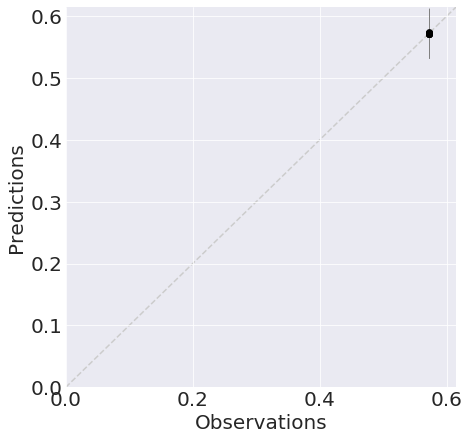

In [49]:
predictions_vs_observations(production_df, xlim=[0, 0.615], ylim=[0, 0.615])

Save dataframe as csv:

In [50]:
df_filename = '../data/ART_recommendations_with_production.csv'
production_df.to_csv(df_filename)


### 6) Generate omics data for the best recommendation

We now obtain the multiomics data for each time point:

In [55]:
proteomics_timeseries = {}
transcriptomics_timeseries = {}
metabolomics_timeseries = {}
metabolomics_oldids_timeseries = {}
fluxomics_timeseries = {}
        
for t in tspan:
    fluxomics_timeseries[t] = solutionsMOMA_TS[0][t].fluxes.to_dict()
    (proteomics_timeseries[t], transcriptomics_timeseries[t], 
     metabolomics_timeseries[t], metabolomics_oldids_timeseries[t]) = omg.get_multiomics(model, 
                                                                                         solutionsMOMA_TS[0][t], 
                                                                                         user_params['mapping_file'], 
                                                                                         old_ids=True)


### Write the multiomics data, cell concentration and external metabolites concentration data into output files

#### EDD data output

Write experiement description:


In [56]:
omg.write_experiment_description_file(user_params['edd_omics_file_path'], line_name='Recommended')


Write OD data:

In [57]:
omg.write_OD_data(cell, user_params['edd_omics_file_path'], line_name='Recommended')


Write external metablites:

In [58]:
omg.write_external_metabolite(Emets, user_params['edd_omics_file_path'], filename='external_metabolites_Rec.csv', linename='Recommended')


Write omics data:

In [59]:
omg.write_omics_files(fluxomics_timeseries, 'fluxomics', user_params, line_name='Recommended')
omg.write_omics_files(proteomics_timeseries, 'proteomics', user_params, line_name='Recommended')
omg.write_omics_files(transcriptomics_timeseries, 'transcriptomics', user_params, line_name='Recommended')
omg.write_omics_files(metabolomics_timeseries, 'metabolomics', user_params, line_name='Recommended')


#### Arrowland data output

Write omics data in separate files for each time point:


In [60]:
omg.write_omics_files(fluxomics_timeseries, 'fluxomics', user_params, line_name='Recommended', al_format=True)
omg.write_omics_files(proteomics_timeseries, 'proteomics', user_params, line_name='Recommended', al_format=True)
omg.write_omics_files(transcriptomics_timeseries, 'transcriptomics', user_params, line_name='Recommended', al_format=True)


Writing the old IDs for metabolomics (used in Arrowland), using the `metabolomics_oldids_timeseries` dictionary.


In [61]:
omg.write_omics_files(metabolomics_oldids_timeseries, 'metabolomics', user_params, line_name='Recommended', al_format=True)
